# <FONT size="10pt"> <center>Projet 6</center></FONT>


### Notebook 1

#### <FONT size="10pt"> <center>Classifiez automatiquement des biens de consommation</center></FONT>


Vous êtes Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.

La mission sera de réaliser une étude de faisabilité d'un moteur de classification automatique d’articles, en utilisant leur image et leur description sur le jeu de données d'articles disponible dans la première pièce jointe de ce mail.

Pourrais-tu analyser les descriptions textuelles et les images des produits, au travers des étapes suivantes : 

- Un prétraitement des données texte et image 
- Une extraction de features 
- Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle 
- Une analyse du graphique afin de conclure, à l’aide des descriptions ou des images, sur la faisabilité de regrouper automatiquement des produits de même catégorie 
- Une réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters

## IMPORTATION DES LIBRAIRIES ET DES DONNEES

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import nltk
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from PIL import Image

pd.set_option('mode.chained_assignment', None) # Pour éviter la survenue de messages d'erreur lors de la création
                                                 # d'un nouveau dataframe à partir d'un existant

from warnings import filterwarnings
filterwarnings('ignore')  # code optionnel

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

#from IPython.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>")) # Largeur écran

### Entreprise "place de marché"

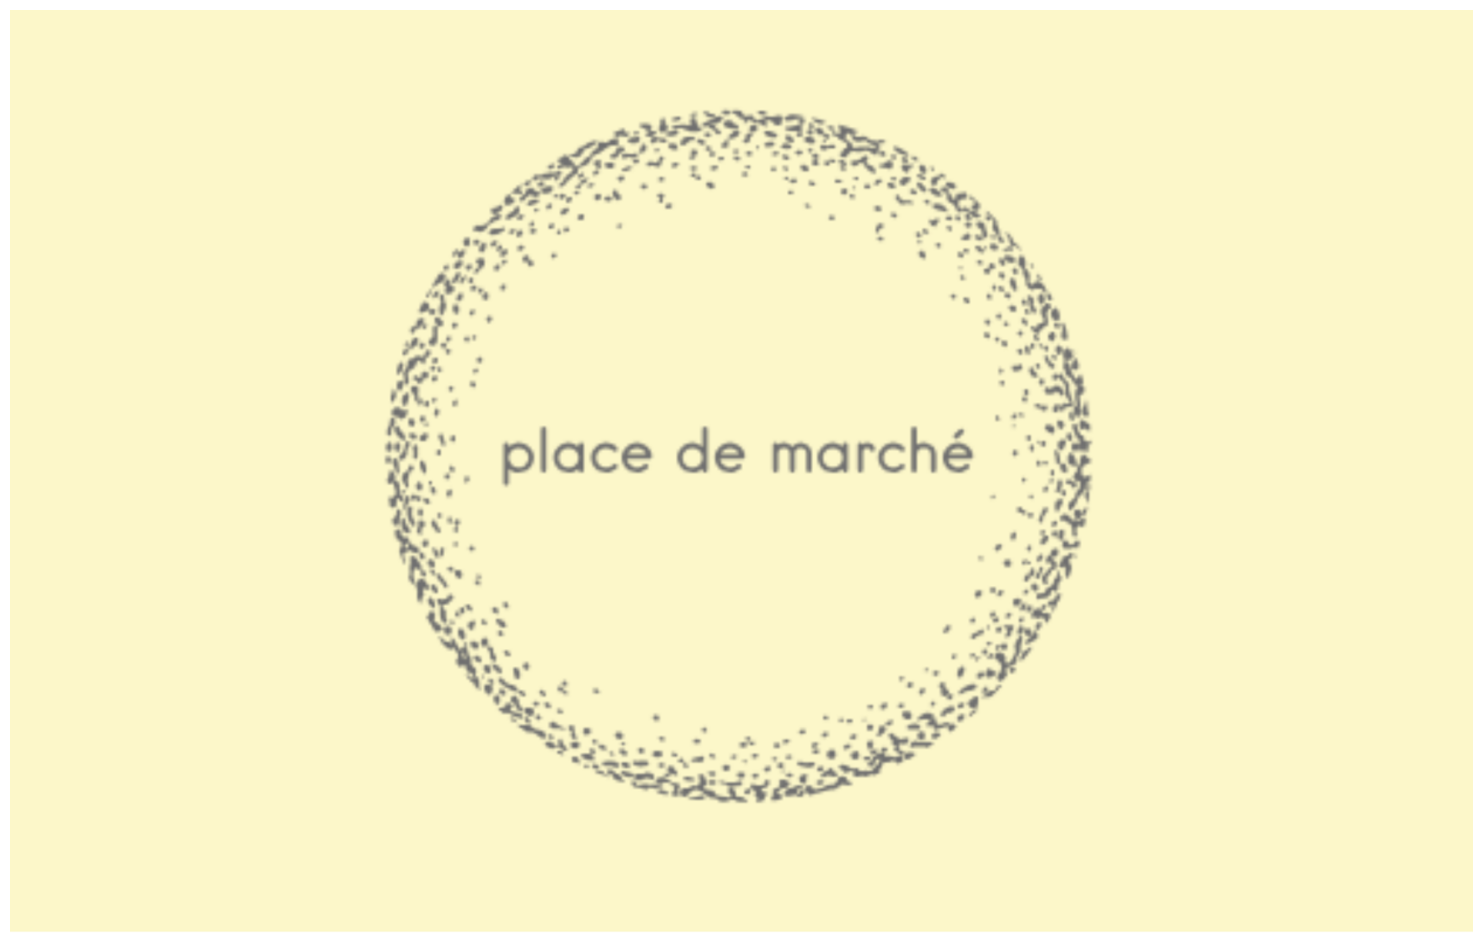

In [10]:
from PIL import Image

# Chemin vers l'image
image_path = 'place_de_marche.png'

# Ouvrir l'image
image = Image.open(image_path)
image = image.convert('RGB')
# Redimensionner l'image (ajuster les dimensions selon vos besoins)
image_resized = image.resize((1900, 1200))

# Ajuster la taille de la figure
plt.figure(figsize=(20, 12))

# Afficher l'image
plt.imshow(image_resized)
plt.axis('off')  # Pour cacher les axes
plt.show()

## Fichier

In [11]:
# Chargement des données
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')

# Affichage du nombre de case
print(f"Nombre total de case est : {len(df)}")

# Affichage des premières lignes du DataFrame
df.head()

Nombre total de case est : 1050


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

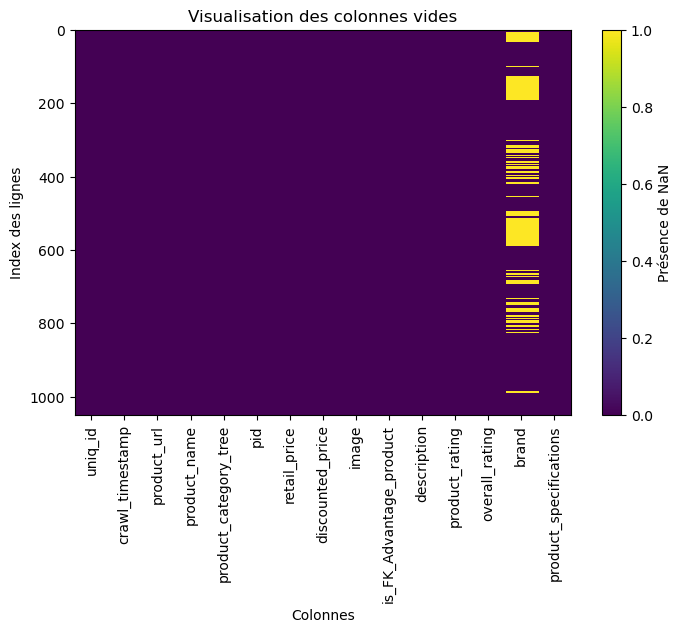

In [13]:
# Visualisation des colonnes vides avec Matplotlib
plt.figure(figsize=(8, 5))
plt.imshow(df.isna(), aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar(label='Présence de NaN')
plt.title('Visualisation des colonnes vides')
plt.xlabel('Colonnes')
plt.ylabel('Index des lignes')
plt.xticks(ticks=np.arange(df.shape[1]), labels=df.columns, rotation=90)
plt.show()

**Nous pouvons observer la colonne marque avec des lignes vides.**

In [14]:
# Doublon
df.duplicated().sum()

0

In [15]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [16]:
# Nombre de valeur unique
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

- Il y a un `uniq_id`, une `product_url`, un `product_name`, un `pid`, une `description` et une `image` différents pour chaque ligne, ce qui signifie que chaque produit est unique et possède ses propres identifiants, URL, nom, description, et image.

In [17]:
# Calculer le nombre total de valeurs manquantes
total_missing_values = df.isna().sum().sum()

# Calculer le nombre total de valeurs dans le DataFrame
total_values = df.shape[0] * df.shape[1]

# Calculer le pourcentage de valeurs manquantes
percentage_missing_values = (total_missing_values / total_values) * 100

print(percentage_missing_values)

2.165079365079365


### Colonne crawl_timestamp

In [18]:
# Conversion de 'crawl_timestamp' en datetime
df['crawl_timestamp'] = pd.to_datetime(df['crawl_timestamp'])

# Extraction de la date à partir de 'crawl_timestamp'
df['crawl_timestamp'] = df['crawl_timestamp'].dt.date

# Calcul du nombre de dates uniques
nombre_dates_uniques = df['crawl_timestamp'].nunique()

# Suppression de la colonne 'crawl_timestamp'
df.drop(columns=['crawl_timestamp'], inplace=True)

# Affichage du nombre de dates uniques
print(nombre_dates_uniques)

87


**Il y a 87 dates uniques, probablement correspondant aux jours de création, ce qui les rend inutiles.**

### Colonne product_category_tree

In [19]:
# Séparation de la colonne 'product_category_tree' en plusieurs niveaux et création de nouvelles colonnes
niv_columns = ['Category_Level_1', 'Category_Level_2', 'Category_Level_3', 'Category_Level_4', 
               'Category_Level_5', 'Category_Level_6', 'Category_Level_7']

df[niv_columns] = df['product_category_tree'].str.split(' >>', expand=True)

# Suppression de la colonne 'product_category_tree' car maintenat unitile
df.drop(columns=['product_category_tree'], inplace=True)

In [20]:
# Définir une fonction pour supprimer les caractères "[" et "]" et les guillemets
def remove_extra_chars(value):
    if isinstance(value, str):
        return value.replace('[', '').replace(']', '').replace('"', '')
    return value

# Liste des colonnes à nettoyer
category_levels = ['Category_Level_1', 'Category_Level_2', 'Category_Level_3', 'Category_Level_4', 
                   'Category_Level_5', 'Category_Level_6', 'Category_Level_7']

# Appliquer la fonction de nettoyage à chaque colonne
df[category_levels] = df[category_levels].applymap(remove_extra_chars)

In [21]:
df.head()

,uniq_id,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,Category_Level_1,Category_Level_2,Category_Level_3,Category_Level_4,Category_Level_5,Category_Level_6,Category_Level_7
0,55b85ea15a1536d46b7190ad6fff8ce7,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None
2,64d5d4a258243731dc7bbb1eef49ad74,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,None
3,d4684dcdc759dd9cdf41504698d737d8,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,None
4,6325b6870c54cd47be6ebfbffa620ec7,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,None


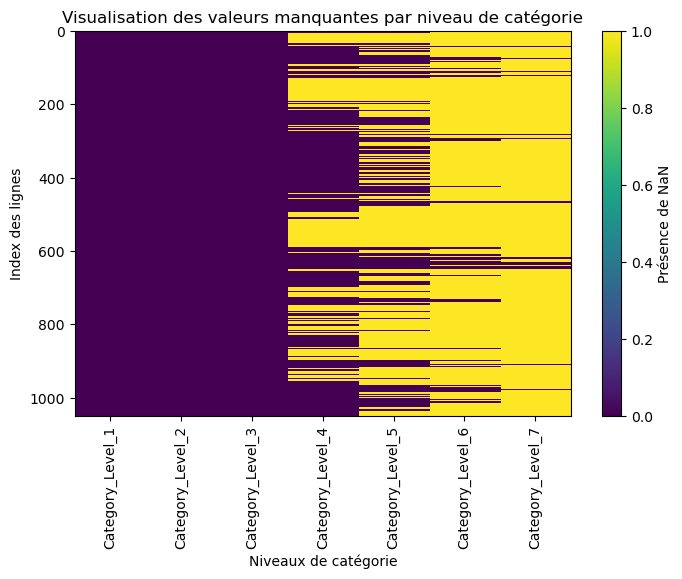

In [22]:
# Liste des colonnes de niveaux de catégories
niveaux_categories = ['Category_Level_1', 'Category_Level_2', 'Category_Level_3', 'Category_Level_4', 
                      'Category_Level_5', 'Category_Level_6', 'Category_Level_7']

# Créer la figure et l'axe
plt.figure(figsize=(8, 5))

# Utiliser imshow pour afficher les valeurs manquantes
plt.imshow(df[niveaux_categories].isna(), aspect='auto', cmap='viridis', interpolation='none')

# Ajouter une barre de couleur
plt.colorbar(label='Présence de NaN')

# Ajouter un titre et des labels
plt.title('Visualisation des valeurs manquantes par niveau de catégorie')
plt.xlabel('Niveaux de catégorie')
plt.ylabel('Index des lignes')

# Ajuster les étiquettes des colonnes
plt.xticks(ticks=np.arange(len(niveaux_categories)), labels=niveaux_categories, rotation=90)

# Afficher le graphique
plt.show()

On constate que **les deux premiers niveaux** sont entièrement remplis. À mesure que l'on progresse vers le niveau 7, les colonnes contiennent de plus en plus de valeurs manquantes.

In [23]:
# Liste des colonnes de niveaux de catégories
niveaux_categories = ['Category_Level_1', 'Category_Level_2', 'Category_Level_3', 'Category_Level_4', 
                      'Category_Level_5', 'Category_Level_6', 'Category_Level_7']

# Boucle à travers chaque niveau de catégorie pour imprimer le nombre de catégories uniques
for i, niveau in enumerate(niveaux_categories, start=1):
    print(f'Nous observons {df[niveau].nunique()} catégories de niveau {i}.')

Nous observons 7 catégories de niveau 1.
Nous observons 62 catégories de niveau 2.
Nous observons 241 catégories de niveau 3.
Nous observons 349 catégories de niveau 4.
Nous observons 297 catégories de niveau 5.
Nous observons 117 catégories de niveau 6.
Nous observons 57 catégories de niveau 7.


**suivre de près les catégories de niveau 3 à 7**

<AxesSubplot:title={'center':'Répartition des catégories'}, ylabel='Category_Level_1'>

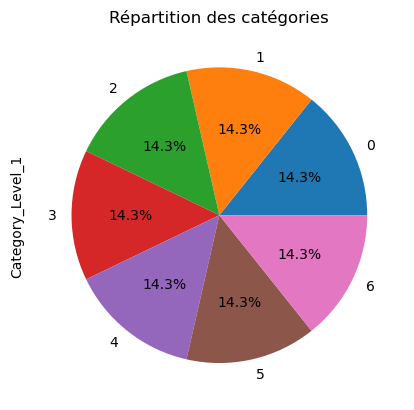

In [56]:
df.Category_Level_1.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des catégories")

### Colonne pid

In [24]:
# Affichage des premières valeurs de la colonne 'pid'
premieres_valeurs_pid = df['pid'].head(3)
print(premieres_valeurs_pid)

# Suppression de la colonne 'pid' du DataFrame
df.drop(columns=['pid'], inplace=True)

0    CRNEG7BKMFFYHQ8Z
1    BTWEGFZHGBXPHZUH
2    BTWEG6SHXTDB2A2Y
Name: pid, dtype: object


**Complexe à comprendre**

### Colonne retail_price et discounted_price

In [25]:
# Affichage des premières valeurs des colonnes 'retail_price' et 'discounted_price'
premieres_valeurs_prix = df[['retail_price', 'discounted_price']].head(3)
print(premieres_valeurs_prix)

# Suppression des colonnes 'retail_price' et 'discounted_price' du DataFrame
df.drop(columns=['retail_price', 'discounted_price'], inplace=True)

   retail_price  discounted_price
0        1899.0             899.0
1         600.0             449.0
2           NaN               NaN


**Tarif standard et tarif promotionnel.**

### Colonne image

In [26]:
# Affichage des premières valeurs des colonnes 'image'
premieres_valeurs_image = df[['image']].head(3)
print(premieres_valeurs_image)

                                  image
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg
1  7b72c92c2f6c40268628ec5f14c6d590.jpg
2  64d5d4a258243731dc7bbb1eef49ad74.jpg


**Intéressant pour la séconde partie de notre projet.**

### Colonne is_FK_Advantage_product

In [27]:
# Affichage des premières valeurs des colonnes 'is_FK_Advantage_product' 
premieres_valeurs_is_FK = df[['is_FK_Advantage_product']].head(3)
print(premieres_valeurs_is_FK)

# Suppression des colonnes 'is_FK_Advantage_product'
df.drop(columns=['is_FK_Advantage_product'], inplace=True)

   is_FK_Advantage_product
0                    False
1                    False
2                    False


**complexe à comprendre**

### Colonne description

In [28]:
# Affichage des premières valeurs des colonnes 'description'
premieres_valeurs_description = df[['description']].head(3)
print(premieres_valeurs_description)

                                         description
0  Key Features of Elegance Polyester Multicolor ...
1  Specifications of Sathiyas Cotton Bath Towel (...
2  Key Features of Eurospa Cotton Terry Face Towe...


**Intéressant pour nos futures analyses.**

### Colonne product_rating et overall_rating (note globale)

In [29]:
# Afficher les comptes des valeurs de 'product_rating'
comptes_product_rating = df['product_rating'].value_counts().head()
print(comptes_product_rating)

# Afficher les comptes des valeurs de 'overall_rating'
comptes_overall_rating = df['overall_rating'].value_counts().head()
print(comptes_overall_rating)

# Filtrer les lignes où 'product_rating' est différent de 'overall_rating'
ratings_differents = df[df['product_rating'] != df['overall_rating']]
#print(ratings_differents)

# Supprimer les colonnes 'product_rating' et 'overall_rating' du DataFrame
df.drop(columns=['product_rating', 'overall_rating'], inplace=True)

ratings_differents

No rating available    889
5                       43
4                       21
3                       12
1                       10
Name: product_rating, dtype: int64
No rating available    889
5                       43
4                       21
3                       12
1                       10
Name: overall_rating, dtype: int64


,uniq_id,product_url,product_name,image,description,product_rating,overall_rating,brand,product_specifications,Category_Level_1,Category_Level_2,Category_Level_3,Category_Level_4,Category_Level_5,Category_Level_6,Category_Level_7


**Ces deux colonnes semblent similaires et fournissent peu d'informations.**

### Colonne brand (marque)

In [30]:
# Affichage des premières valeurs des colonnes 'brand'
premieres_valeurs_brand = df[['brand']].head(3)
print(premieres_valeurs_brand)

# Affichage des comptes des valeurs de la colonne 'brand', y compris les valeurs manquantes
comptes_marques = df['brand'].value_counts(dropna=False)
print(comptes_marques)

# Suppression de la colonne 'brand' du DataFrame
df.drop(columns=['brand'], inplace=True)

      brand
0  Elegance
1  Sathiyas
2   Eurospa
NaN                   338
Lapguard               11
PRINT SHAPES           11
Lal Haveli             10
Raymond                 8
                     ... 
Rute                    1
NAMS                    1
JewelKraft Designs      1
Budding Bees            1
Mee Mee                 1
Name: brand, Length: 491, dtype: int64


**Colonne intéressante, mais avec beaucoup de valeurs manquantes, elle n'est donc pas utile.**

### Colonne product_specifications

In [31]:
# Afficher la valeur de la deuxième ligne de la colonne 'product_specifications'
specification_deuxieme_ligne = df.loc[1, 'product_specifications']
print(specification_deuxieme_ligne)

{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {"key"=>"Size", "value"=>"Mediam"}, {"key"=>"Length", "value"=>"30 inch"}, {"key"=>"Width", "value"=>"60 inch"}, {"key"=>"Number of Contents in Sales Package", "value"=>"3"}, {"key"=>"Sales Package", "value"=>"3 Bath Towel"}]}


**Complexité de compréhension**

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uniq_id                 1050 non-null   object
 1   product_url             1050 non-null   object
 2   product_name            1050 non-null   object
 3   image                   1050 non-null   object
 4   description             1050 non-null   object
 5   product_specifications  1049 non-null   object
 6   Category_Level_1        1050 non-null   object
 7   Category_Level_2        1050 non-null   object
 8   Category_Level_3        1047 non-null   object
 9   Category_Level_4        679 non-null    object
 10  Category_Level_5        405 non-null    object
 11  Category_Level_6        127 non-null    object
 12  Category_Level_7        57 non-null     object
dtypes: object(13)
memory usage: 106.8+ KB


## Nettoyage des données textuelles

Ce code importe la bibliothèque `nltk` et télécharge les corpus populaires ainsi que les autres ressources nécessaires pour de nombreuses tâches de traitement de texte, tout en supprimant les messages de sortie pendant le téléchargement grâce à l'argument `quiet=True`.

In [33]:
import nltk
nltk.download('popular', quiet=True)

True

In [34]:
# Calcul de la longueur des noms de produits en nombre de mots
longueurs_noms = df['product_name'].apply(lambda x: len(x.split(' ')))

# Affichage de la longueur minimale des noms de produits
longueur_min = longueurs_noms.min()
print(f'La longueur minimum du nom de produit est de {longueur_min}')

# Affichage de la longueur maximale des noms de produits
longueur_max = longueurs_noms.max()
print(f'La longueur maximum du nom de produit est de {longueur_max}')

La longueur minimum du nom de produit est de 2
La longueur maximum du nom de produit est de 27


In [35]:
# Calcul du nombre de mots dans chaque description de produit
longueurs_descriptions = df['description'].apply(lambda x: len(x.split(' ')))

# Affichage de la longueur minimale des descriptions de produits
longueur_min_description = longueurs_descriptions.min()
print(f'La longueur minimum de la description est de {longueur_min_description} mots')

# Affichage de la longueur maximale des descriptions de produits
longueur_max_description = longueurs_descriptions.max()
print(f'La longueur maximum de la description est de {longueur_max_description} mots')

La longueur minimum de la description est de 18 mots
La longueur maximum de la description est de 589 mots


#### Création d'une variable combinant "product_name" et "description"

In [36]:
# Combiner les colonnes 'product_name' et 'description' pour créer la colonne 'DescriptionComplete'
df['DescriptionComplete'] = df['product_name'] + df['description']    # + ' ' +

# Afficher les premières valeurs de la nouvelle colonne 'DescriptionComplete'
premieres_valeurs_description_complete = df['DescriptionComplete'].head(3)
print(premieres_valeurs_description_complete)

0    Elegance Polyester Multicolor Abstract Eyelet ...
1    Sathiyas Cotton Bath TowelSpecifications of Sa...
2    Eurospa Cotton Terry Face Towel SetKey Feature...
Name: DescriptionComplete, dtype: object


In [37]:
# Calcul du nombre de mots dans chaque description complète
longueurs_description_complete = df['DescriptionComplete'].apply(lambda x: len(x.split(' ')))

# Affichage de la longueur minimale des descriptions complètes
longueur_min_description_complete = longueurs_description_complete.min()
print(f'La longueur minimum de la description complète est de {longueur_min_description_complete} mots')

# Affichage de la longueur maximale des descriptions complètes
longueur_max_description_complete = longueurs_description_complete.max()
print(f'La longueur maximum de la description complète est de {longueur_max_description_complete} mots')

La longueur minimum de la description complète est de 21 mots
La longueur maximum de la description complète est de 593 mots


In [38]:
# Calculer la distribution de fréquence des mots dans chaque description complète
frequence_mots_descriptions = df['DescriptionComplete'].apply(lambda x: nltk.FreqDist(x.split(" ")))

# Afficher les distributions de fréquence des mots pour les cinq premières descriptions complètes
frequence_mots_premieres_descriptions = frequence_mots_descriptions.head()
print(frequence_mots_premieres_descriptions)

0    {'Elegance': 4, 'Polyester': 6, 'Multicolor': ...
1    {'Sathiyas': 4, 'Cotton': 3, 'Bath': 6, 'Towel...
2    {'Eurospa': 6, 'Cotton': 5, 'Terry': 5, 'Face'...
3    {'SANTOSH': 4, 'ROYAL': 4, 'FASHION': 4, 'Cott...
4    {'Jaipur': 4, 'Print': 5, 'Cotton': 5, 'Floral...
Name: DescriptionComplete, dtype: object


**La tokenisation** est le processus de décomposition d'un texte en unités plus petites appelées "tokens". Ces unités peuvent être des mots, des phrases ou même des caractères individuels, en fonction de l'objectif de l'analyse. La tokenisation est une étape fondamentale dans le traitement automatique du langage naturel (NLP), car elle permet de préparer le texte brut pour une analyse plus approfondie.

In [39]:
# Définir une fonction pour la tokenisation et la mise en minuscule
def tokenizer(texte):
    texte = texte.lower()  # Convertir en minuscule
    tokens = nltk.word_tokenize(texte)  # Tokeniser le texte
    return tokens

# Appliquer la fonction de tokenisation sur la colonne 'DescriptionComplete'
df['DescriptionCompleteTokenizer'] = df['DescriptionComplete'].apply(tokenizer)

# Afficher les trois premières valeurs de la nouvelle colonne 'DescriptionCompleteTokenizer'
premieres_valeurs_tokenizer = df['DescriptionCompleteTokenizer'].head(3)
print(premieres_valeurs_tokenizer)

0    [elegance, polyester, multicolor, abstract, ey...
1    [sathiyas, cotton, bath, towelspecifications, ...
2    [eurospa, cotton, terry, face, towel, setkey, ...
Name: DescriptionCompleteTokenizer, dtype: object


**Les stop words (ou "mots vides" en français)** sont des mots courants dans une langue qui sont généralement filtrés et supprimés lors du traitement du langage naturel (NLP). Ces mots n'apportent souvent pas de valeur significative pour l'analyse textuelle, car ils apparaissent fréquemment et n'aident pas à distinguer un texte d'un autre.

In [40]:
# Définir une fonction pour supprimer les stop words et les ponctuations
def supprimer_stop_words_et_ponctuations(tokens):
    stop_words = set(nltk.corpus.stopwords.words("english"))
    # Filtrer les tokens pour supprimer les stop words
    tokens_sans_stop_words = [word for word in tokens if word not in stop_words]
    # Filtrer les tokens pour supprimer les mots non alphabétiques (ponctuation, chiffres, etc.)
    tokens_sans_ponctuations = [word for word in tokens_sans_stop_words if word.isalpha()]
    return tokens_sans_ponctuations

# Appliquer la fonction sur la colonne 'DescriptionCompleteTokenizer'
df['DescriptionCompleteTokenizer'] = df['DescriptionCompleteTokenizer'].apply(supprimer_stop_words_et_ponctuations)

# Afficher les trois premières valeurs de la nouvelle colonne 'DescriptionCompleteTokenizer'
premieres_valeurs_tokenizer_sans_stopwords = df['DescriptionCompleteTokenizer'].head(3)
print(premieres_valeurs_tokenizer_sans_stopwords)

0    [elegance, polyester, multicolor, abstract, ey...
1    [sathiyas, cotton, bath, towelspecifications, ...
2    [eurospa, cotton, terry, face, towel, setkey, ...
Name: DescriptionCompleteTokenizer, dtype: object


In [41]:
# Calcul de la longueur des descriptions complètes après nettoyage
longueurs_descriptions = df['DescriptionCompleteTokenizer'].apply(len)

# Affichage de la longueur minimale des descriptions complètes après nettoyage
longueur_min_description = longueurs_descriptions.min()
print(f'La longueur minimale des descriptions complètes après nettoyage est de {longueur_min_description} mots')

# Affichage de la longueur maximale des descriptions complètes après nettoyage
longueur_max_description = longueurs_descriptions.max()
print(f'La longueur maximale des descriptions complètes après nettoyage est de {longueur_max_description} mots')

# Calcul de la fréquence des mots dans toutes les descriptions complètes
tous_les_mots = df['DescriptionCompleteTokenizer'].sum()
frequence_mots = pd.Series(tous_les_mots).value_counts()

# Affichage de la fréquence minimale des mots dans toutes les descriptions complètes
frequence_min = frequence_mots.min()
print(f'La fréquence minimale d\'apparition des mots dans toutes les descriptions complètes est de {frequence_min}')

# Affichage de la fréquence maximale des mots dans toutes les descriptions complètes
frequence_max = frequence_mots.max()
print(f'La fréquence maximale d\'apparition des mots dans toutes les descriptions complètes est de {frequence_max}')

La longueur minimale des descriptions complètes après nettoyage est de 10 mots
La longueur maximale des descriptions complètes après nettoyage est de 365 mots
La fréquence minimale d'apparition des mots dans toutes les descriptions complètes est de 1
La fréquence maximale d'apparition des mots dans toutes les descriptions complètes est de 632


**Le stemming** est un processus en traitement du langage naturel (NLP) qui consiste à réduire les mots à leur racine ou base commune (appelée "stem"). L'objectif du stemming est de regrouper différentes formes d'un mot pour qu'elles soient traitées de manière identique. Par exemple, les mots "running", "runner", "ran", et "runs" peuvent être réduits à la même racine "run".

In [42]:
from nltk.stem import SnowballStemmer

# Initialiser le stemmer anglais de Snowball
stem_en = SnowballStemmer("english")

# Définir une fonction pour appliquer le stemming sur une liste de tokens
def stemming(tokens):
    return [stem_en.stem(word) for word in tokens]

# Appliquer la fonction de stemming sur la colonne 'DescriptionCompleteTokenizer'
df['DescriptionCompleteTokenizer'] = df['DescriptionCompleteTokenizer'].apply(stemming)

# Afficher les premières valeurs de la colonne 'DescriptionCompleteTokenizer' après stemming
premieres_valeurs_stemming = df['DescriptionCompleteTokenizer'].head()
print(premieres_valeurs_stemming)

0    [eleg, polyest, multicolor, abstract, eyelet, ...
1    [sathiya, cotton, bath, towelspecif, sathiya, ...
2    [eurospa, cotton, terri, face, towel, setkey, ...
3    [santosh, royal, fashion, cotton, print, king,...
4    [jaipur, print, cotton, floral, king, size, do...
Name: DescriptionCompleteTokenizer, dtype: object


In [43]:
# Calcul de la longueur des descriptions complètes après nettoyage et stemming
longueurs_descriptions_stemmed = df['DescriptionCompleteTokenizer'].apply(len)

# Affichage de la longueur minimale des descriptions complètes après nettoyage et stemming
longueur_min_description_stemmed = longueurs_descriptions_stemmed.min()
print(f'La longueur minimale des descriptions complètes après nettoyage et stemming est de {longueur_min_description_stemmed} mots')

# Affichage de la longueur maximale des descriptions complètes après nettoyage et stemming
longueur_max_description_stemmed = longueurs_descriptions_stemmed.max()
print(f'La longueur maximale des descriptions complètes après nettoyage et stemming est de {longueur_max_description_stemmed} mots')

# Calcul de la fréquence des mots dans toutes les descriptions complètes après stemming
tous_les_mots_stemmed = df['DescriptionCompleteTokenizer'].sum()
frequence_mots_stemmed = pd.Series(tous_les_mots_stemmed).value_counts()

# Affichage de la fréquence minimale des mots dans toutes les descriptions complètes après stemming
frequence_min_stemmed = frequence_mots_stemmed.min()
print(f'La fréquence minimale d\'apparition des mots dans toutes les descriptions complètes après stemming est de {frequence_min_stemmed}')

# Affichage de la fréquence maximale des mots dans toutes les descriptions complètes après stemming
frequence_max_stemmed = frequence_mots_stemmed.max()
print(f'La fréquence maximale d\'apparition des mots dans toutes les descriptions complètes après stemming est de {frequence_max_stemmed}')

La longueur minimale des descriptions complètes après nettoyage et stemming est de 10 mots
La longueur maximale des descriptions complètes après nettoyage et stemming est de 365 mots
La fréquence minimale d'apparition des mots dans toutes les descriptions complètes après stemming est de 1
La fréquence maximale d'apparition des mots dans toutes les descriptions complètes après stemming est de 870


**Le lemmatizer (ou "lemmatisation" en français)** est un processus en traitement du langage naturel (NLP) qui consiste à réduire les mots à leur forme canonique ou de base, appelée "lemme". Par exemple, dans une phrase comme "Les chats mangeaient des poissons", la lemmatisation transformerait "chats" en "chat", "mangeaient" en "manger", et "poissons" en "poisson". Contrairement au stemming, qui coupe simplement les suffixes pour obtenir la racine du mot, la lemmatisation prend en compte le contexte et la signification du mot pour le ramener à sa forme de base.

In [44]:
# Installez manuellement le modèle via spaCy :

import spacy.cli
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [45]:
import spacy

# Charger le modèle linguistique de spaCy pour l'anglais
nlp = spacy.load('en_core_web_sm')

# Définir une fonction pour appliquer la lemmatisation sur une liste de tokens
def lemmatizer(tokens):
    # Joindre les tokens en une seule chaîne de caractères
    texte = ' '.join(tokens)
    # Traiter le texte avec spaCy pour obtenir des objets Token
    doc = nlp(texte)
    # Extraire les lemmes de chaque token
    lemmes = [token.lemma_ for token in doc]
    return lemmes

# Appliquer la fonction de lemmatisation sur la colonne 'DescriptionCompleteTokenizer'
df['DescriptionCompleteTokenizer'] = df['DescriptionCompleteTokenizer'].apply(lemmatizer)

# Afficher les premières valeurs de la colonne 'DescriptionCompleteTokenizer' après lemmatisation
premieres_valeurs_lemmatizer = df['DescriptionCompleteTokenizer'].head()
print(premieres_valeurs_lemmatizer)  

0    [eleg, polyest, multicolor, abstract, eyelet, ...
1    [sathiya, cotton, bath, towelspecif, sathiya, ...
2    [eurospa, cotton, terri, face, towel, setkey, ...
3    [santosh, royal, fashion, cotton, print, king,...
4    [jaipur, print, cotton, floral, king, size, do...
Name: DescriptionCompleteTokenizer, dtype: object


In [46]:
# Calcul de la longueur des descriptions complètes après nettoyage et lemmatisation
longueurs_descriptions_lemmatized = df['DescriptionCompleteTokenizer'].apply(len)

# Affichage de la longueur minimale des descriptions complètes après nettoyage et lemmatisation
longueur_min_description_lemmatized = longueurs_descriptions_lemmatized.min()
print(f'La longueur minimale des descriptions complètes après nettoyage et lemmatisation est de {longueur_min_description_lemmatized} mots')

# Affichage de la longueur maximale des descriptions complètes après nettoyage et lemmatisation
longueur_max_description_lemmatized = longueurs_descriptions_lemmatized.max()
print(f'La longueur maximale des descriptions complètes après nettoyage et lemmatisation est de {longueur_max_description_lemmatized} mots')

# Calcul de la fréquence des mots dans toutes les descriptions complètes après lemmatisation
tous_les_mots_lemmatized = df['DescriptionCompleteTokenizer'].sum()
frequence_mots_lemmatized = pd.Series(tous_les_mots_lemmatized).value_counts()

# Affichage de la fréquence minimale des mots dans toutes les descriptions complètes après lemmatisation
frequence_min_lemmatized = frequence_mots_lemmatized.min()
print(f'La fréquence minimale d\'apparition des mots dans toutes les descriptions complètes après lemmatisation est de {frequence_min_lemmatized}')

# Affichage de la fréquence maximale des mots dans toutes les descriptions complètes après lemmatisation
frequence_max_lemmatized = frequence_mots_lemmatized.max()
print(f'La fréquence maximale d\'apparition des mots dans toutes les descriptions complètes après lemmatisation est de {frequence_max_lemmatized}')

La longueur minimale des descriptions complètes après nettoyage et lemmatisation est de 10 mots
La longueur maximale des descriptions complètes après nettoyage et lemmatisation est de 365 mots
La fréquence minimale d'apparition des mots dans toutes les descriptions complètes après lemmatisation est de 1
La fréquence maximale d'apparition des mots dans toutes les descriptions complètes après lemmatisation est de 870


In [47]:
# Combiner les mots restants en une seule phrase
#df['DescriptionCompleteTokenizer'] = df['DescriptionCompleteTokenizer'].apply(lambda tokens: ' '.join(map(str, tokens)))

In [48]:
# Combiner les mots restants en une seule phrase

def join_tokens(tokens):
    return ' '.join(str(word) for word in tokens)

df['DescriptionCompleteTokenizer'] = df['DescriptionCompleteTokenizer'].apply(join_tokens)

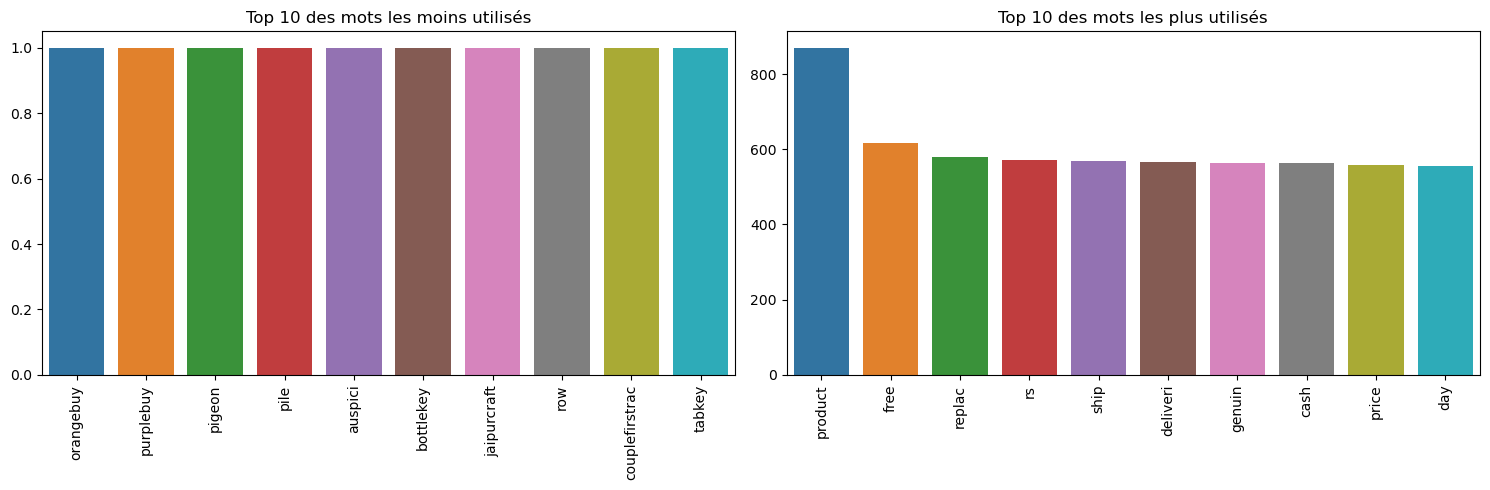

In [49]:
# Combiner les mots restants en une seule chaîne de caractères
all_words = ' '.join(df['DescriptionCompleteTokenizer'])

# Calculer la fréquence des mots
freq_dist = nltk.FreqDist(all_words.split())

# Convertir la fréquence des mots en DataFrame et trier par fréquence décroissante
freq_df = pd.DataFrame.from_dict(freq_dist, orient='index', columns=['Frequency'])
freq_df = freq_df.sort_values(by='Frequency', ascending=False).reset_index()
freq_df.columns = ['Word', 'Frequency']

# Créer des sous-plots pour les graphiques des mots les plus et les moins utilisés
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graphique des 10 mots les moins utilisés
sns.barplot(x='Word', y='Frequency', data=freq_df.tail(10), ax=axes[0])
axes[0].set_title('Top 10 des mots les moins utilisés')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Graphique des 10 mots les plus utilisés
sns.barplot(x='Word', y='Frequency', data=freq_df.head(10), ax=axes[1])
axes[1].set_title('Top 10 des mots les plus utilisés')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Afficher les graphiques
plt.tight_layout()
plt.show()

## Illustration linguistique

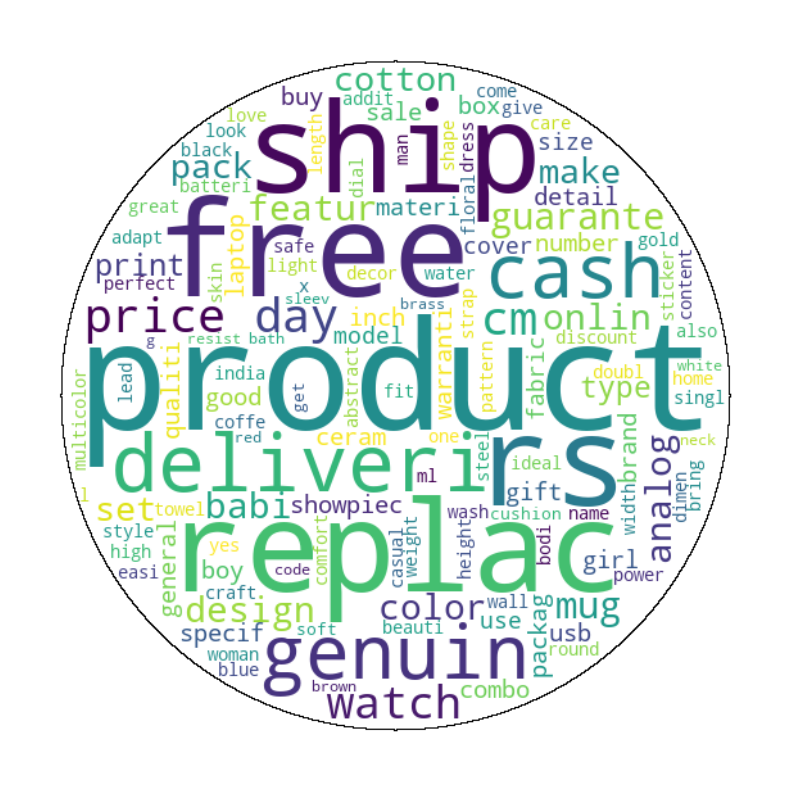

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
import nltk
import pandas as pd

# Charger l'image de masque
mask_path = "etendu.png"  # Assurez-vous que le chemin est correct
masque = np.array(Image.open(mask_path))

# Initialiser le générateur de nuage de mots avec le masque
wordcloud = WordCloud(
    width=800, 
    height=800, 
    max_font_size=200, 
    min_font_size=10,
    background_color='white', 
    mask=masque, 
    contour_width=0.1
)

# Combiner les mots de la colonne 'DescriptionCompleteTokenizer' en une seule chaîne
mots_combines = ' '.join(df['DescriptionCompleteTokenizer'])

# Générer la distribution de fréquence des mots
frequence_mots = nltk.FreqDist(mots_combines.split())

# Générer le nuage de mots à partir des fréquences des mots
wordcloud.generate_from_frequencies(frequence_mots)

# Afficher le nuage de mots
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Modification de la colonne cible

In [51]:
# Calculer le nombre d'occurrences de chaque valeur dans la colonne 'Category_Level_2'
valeurs_comptes = df['Category_Level_2'].value_counts()

# Trier les valeurs comptées par ordre croissant
valeurs_comptes_tries = valeurs_comptes.sort_values()

# Afficher les valeurs comptées triées
print(valeurs_comptes_tries)

 Beauty Accessories                   1
 Dinnerware & Crockery                1
 Garden & Leisure                     1
 Clocks                               1
 Housekeeping & Laundry               1
 Men's Grooming                       1
 Women's Hygiene                      1
 Pressure Cookers & Pans              1
 Kripa's Home Furnishing              1
 Strollers & Activity Gear            1
 Software                             1
 Candles & Fragrances                 1
 Consumables & Disposables            1
 TRUE Home Decor & Festive Needs      1
 JMD Home Furnishing                  1
 Tidy Home Furnishing                 1
 Laptops                              2
 Computer Components                  2
 Storage                              2
 Eye Care                             2
 Furniture & Furnishings              2
 Tableware & Cutlery                  3
 Living Room Furnishing               3
 Tablet Accessories                   3
 Religion & Devotion                  3


In [52]:
# Copier les valeurs de la colonne 'Category_Level_1' dans une nouvelle colonne 'Category_Level_1_Texte'
df['Category_Level_1_Texte'] = df['Category_Level_1']

# Factoriser la colonne 'Category_Level_1' en assignant des codes numériques à chaque catégorie unique
df['Category_Level_1'], _ = pd.factorize(df['Category_Level_1'])

## Export

In [53]:
df.to_csv("Data_Final_cleaning_projet_6", index=False)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   uniq_id                       1050 non-null   object
 1   product_url                   1050 non-null   object
 2   product_name                  1050 non-null   object
 3   image                         1050 non-null   object
 4   description                   1050 non-null   object
 5   product_specifications        1049 non-null   object
 6   Category_Level_1              1050 non-null   int64 
 7   Category_Level_2              1050 non-null   object
 8   Category_Level_3              1047 non-null   object
 9   Category_Level_4              679 non-null    object
 10  Category_Level_5              405 non-null    object
 11  Category_Level_6              127 non-null    object
 12  Category_Level_7              57 non-null     object
 13  DescriptionComplet

In [55]:
df

,uniq_id,product_url,product_name,image,description,product_specifications,Category_Level_1,Category_Level_2,Category_Level_3,Category_Level_4,Category_Level_5,Category_Level_6,Category_Level_7,DescriptionComplete,DescriptionCompleteTokenizer,Category_Level_1_Texte
0,55b85ea15a1536d46b7190ad6fff8ce7,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",0,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None,Elegance Polyester Multicolor Abstract Eyelet ...,eleg polyest multicolor abstract eyelet door c...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,"{""product_specification""=>[{""key""=>""Machine Wa...",1,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None,Sathiyas Cotton Bath TowelSpecifications of Sa...,sathiya cotton bath towelspecif sathiya cotton...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,"{""product_specification""=>[{""key""=>""Material"",...",1,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,None,Eurospa Cotton Terry Face Towel SetKey Feature...,eurospa cotton terri face towel setkey featur ...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,"{""product_specification""=>[{""key""=>""Brand"", ""v...",0,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,None,SANTOSH ROYAL FASHION Cotton Printed King size...,santosh royal fashion cotton print king size d...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,"{""product_specification""=>[{""key""=>""Machine Wa...",0,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,None,Jaipur Print Cotton Floral King sized Double B...,jaipur print cotton floral king size doubl bed...,Home Furnishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Oren Empower Extra Large Self Adhesive Sticker...,"{""product_specification""=>[{""key""=>""Number of ...",1,Baby & Kids Gifts,Stickers,Oren Empower Stickers,None,None,None,Oren Empower Extra Large Self Adhesive Sticker...,oren empow extra larg self adhe stickeroren em...,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"{""product_specification""=>[{""key""=>""Number of ...",1,Baby & Kids Gifts,Stickers,Wallmantra Stickers,None,None,None,Wallmantra Large Vinyl Sticker StickerWallmant...,wallmantra larg vinyl sticker stickerwallmantr...,Baby Care
1047,5912e037d12774bb73a2048f35a00009,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"{""product_specification""=>[{""key""=>""Number of 